# Classification

In [ ]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

### Define and train model, get calibration probabilities

In [90]:
# Generate synthetic dataset
X, y = datasets.make_classification(n_samples=10000, n_features=20, n_classes=10, n_informative=15, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

model = MLPClassifier(hidden_layer_sizes=(50,5), activation='relu', solver='adam', max_iter=5000, random_state=42)
model.fit(X_train, y_train)

calib_probs = model.predict_proba(X_calib)
test_probs = model.predict_proba(X_test)
CP = {"TPS": {}, "APS": {}, "RAPS": {}}

# Print set sizes
print(f"Training set size: {len(y_train)}")
print(f"Calibration set size: {len(y_calib)}")
print(f"Test set size: {len(y_test)}")

Training set size: 6000
Calibration set size: 2000
Test set size: 2000


### Thresshold predictive sets (TPS)

In [91]:
# Calibration scores
n = len(y_calib)
alpha = 0.1
q_level = np.ceil((n+1)*(1-alpha))/n
print("Corrected quantile level: ", np.round(q_level, 3))


cal_scores_tps = 1-calib_probs[np.arange(n),y_calib]
q_hat = np.quantile(cal_scores_tps, q_level, method='higher')
print("q_hat: ", np.round(q_hat, 3))



# Compute prediction sets and empirical coverage
prediction_sets_TPS = test_probs >= (1-q_hat)
empirical_coverage_TPS = prediction_sets_TPS[np.arange(len(test_probs)), y_test].mean()
print(f"The empirical coverage is: {np.round(empirical_coverage_TPS, 3)}")

# Define prediction sets
preds_TPS = {}
for i in range(len(test_probs)):
    preds_TPS[i] = [int(j) for j in np.where(test_probs[i] >=  (1-q_hat))[0]]

# Print a few test examples with their prediction sets
for i in range(5):
    print(f"Test example {i}, true label: {y_test[i]}, prediction set: {preds_TPS[i]}")

# Save prediction sets to CP dictionary
CP["TPS"]['cal_scores'] = cal_scores_tps
CP["TPS"]['q_hat'] = q_hat
CP["TPS"]['prediction_sets'] = preds_TPS
CP["TPS"]['empirical_coverage'] = empirical_coverage_TPS

Corrected quantile level:  0.9
q_hat:  0.962
The empirical coverage is: 0.909
Test example 0, true label: 8, prediction set: [6, 7, 8, 9]
Test example 1, true label: 5, prediction set: [3, 5]
Test example 2, true label: 7, prediction set: [6, 7, 9]
Test example 3, true label: 5, prediction set: [5, 6, 7, 8, 9]
Test example 4, true label: 3, prediction set: [2, 3]


### Adaptive prediction sets

In [92]:
# Adaptive Prediction Sets (APS)
# Compute calibration scores
true_prob = calib_probs[np.arange(n), y_calib]                                              # true class probabilities
cal_pi = calib_probs.argsort(1)[:,::-1]                                                     # Indices that would sort probs descending
cal_srt = np.take_along_axis(calib_probs, cal_pi, axis=1).cumsum(axis=1)                    # Sorted cumulative sums
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), y_calib] # Get scores for true class
cal_scores = cal_scores - true_prob                                                         # Subtract true class prob to get conformity scores

# Get the score quantile
q_hat = np.quantile(cal_scores, q_level, interpolation='higher')

# Get prediction sets for test data
test_pi = test_probs.argsort(1)[:,::-1]                                     # Indices that would sort test probs descending
test_srt = np.take_along_axis(test_probs, test_pi, axis=1).cumsum(axis=1)   # Sorted cumulative sums

# Define prediction sets
mask = test_srt < q_hat                                                         # classes strictly below qhat
first_cross = (test_srt >= q_hat).argmax(axis=1)                                # index of first crossing
mask[np.arange(len(mask)), first_cross] = True                                  # ensure inclusion of crossing class
prediction_sets_aps = np.take_along_axis(mask, test_pi.argsort(axis=1), axis=1) # Get prediction sets, all values with cumsum less than q_hat

empirical_coverage_aps = prediction_sets_aps[np.arange(prediction_sets_aps.shape[0]),y_test].mean()

preds_aps = {}
for i in range(len(test_probs)):
    preds_aps[i] = [int(j) for j in np.where(prediction_sets_aps[i])[0]]

# Print a few test examples with their prediction sets
print(f"The empirical coverage is: {np.round(empirical_coverage_aps, 3)}")
print("APS Prediction Sets:")
for i in range(5):
    print(f"Test example {i}, true label: {y_test[i]}, prediction set: {preds_aps[i]}")

# Save to CP dictionary
CP["APS"]['cal_scores'] = cal_scores
CP["APS"]['q_hat'] = q_hat
CP["APS"]['prediction_sets'] = preds_aps
CP["APS"]['empirical_coverage'] = empirical_coverage_aps

The empirical coverage is: 0.91
APS Prediction Sets:
Test example 0, true label: 8, prediction set: [7, 8, 9]
Test example 1, true label: 5, prediction set: [3, 5]
Test example 2, true label: 7, prediction set: [7, 9]
Test example 3, true label: 5, prediction set: [5, 6, 7, 8, 9]
Test example 4, true label: 3, prediction set: [3]


### RAPS

In [93]:
lam = 0.02  # penalty parameter
k = 2       # rank threshold

# Compute the rank of the true label for each sample
true_ranks = cal_pi.argsort(axis=1)[np.arange(n), y_calib]    # 0 = best, 1 = second, ...

# Apply penalty for ranks deeper than k
penalty = lam * np.maximum(true_ranks - k, 0)

# RAPS conformity scores
cal_scores_raps = cal_scores + penalty

# Get the score quantile
q_hat = np.quantile(cal_scores_raps, q_level, interpolation='higher')

# Define prediction sets
mask = test_srt < q_hat                                                          # classes strictly below qhat
first_cross = (test_srt >= q_hat).argmax(axis=1)                                 # index of first crossing
mask[np.arange(len(mask)), first_cross] = True                                   # ensure inclusion of crossing class
prediction_sets_raps = np.take_along_axis(mask, test_pi.argsort(axis=1), axis=1) # Get prediction sets, all values with cumsum less than q_hat

empirical_coverage_raps = prediction_sets_raps[np.arange(prediction_sets_raps.shape[0]),y_test].mean()

preds_raps = {}
for i in range(len(test_probs)):
    preds_raps[i] = [int(j) for j in np.where(prediction_sets_raps[i])[0]]

# Print a few test examples with their prediction sets
print(f"The empirical coverage is: {np.round(empirical_coverage_raps, 3)}")
print("RAPS Prediction Sets:")
for i in range(5):
    print(f"Test example {i}, true label: {y_test[i]}, prediction set: {preds_raps[i]}")

# Save to CP dictionary
CP["RAPS"]['cal_scores'] = cal_scores_raps
CP["RAPS"]['q_hat'] = q_hat
CP["RAPS"]['prediction_sets'] = preds_raps
CP["RAPS"]['empirical_coverage'] = empirical_coverage_raps

The empirical coverage is: 0.93
RAPS Prediction Sets:
Test example 0, true label: 8, prediction set: [6, 7, 8, 9]
Test example 1, true label: 5, prediction set: [3, 5]
Test example 2, true label: 7, prediction set: [6, 7, 9]
Test example 3, true label: 5, prediction set: [5, 6, 7, 8, 9]
Test example 4, true label: 3, prediction set: [2, 3]


# Compare methods


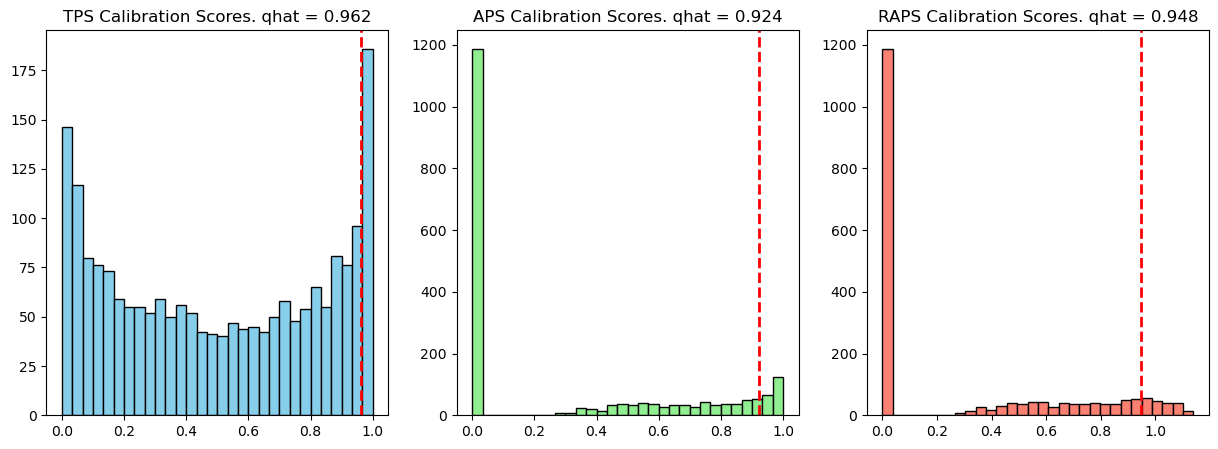

In [94]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].hist(CP["TPS"]['cal_scores'], bins=30, color='skyblue', edgecolor='black')
ax[0].axvline(CP["TPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[0].set_title('TPS Calibration Scores. qhat = {:.3f}'.format(CP["TPS"]['q_hat']))

ax[1].hist(CP["APS"]['cal_scores'], bins=30, color='lightgreen', edgecolor='black')
ax[1].axvline(CP["APS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[1].set_title('APS Calibration Scores. qhat = {:.3f}'.format(CP["APS"]['q_hat']))

ax[2].hist(CP["RAPS"]['cal_scores'], bins=30, color='salmon', edgecolor='black')
ax[2].axvline(CP["RAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[2].set_title('RAPS Calibration Scores. qhat = {:.3f}'.format(CP["RAPS"]['q_hat']))
plt.show()

In [95]:
for i in range(5):
    print(f"Test example {i}, true label: {y_test[i]}")
    print(f"  TPS prediction set:  {preds_TPS[i]}")
    print(f"  APS prediction set:  {preds_aps[i]}")
    print(f"  RAPS prediction set: {preds_raps[i]}")
    print()

Test example 0, true label: 8
  TPS prediction set:  [6, 7, 8, 9]
  APS prediction set:  [7, 8, 9]
  RAPS prediction set: [6, 7, 8, 9]

Test example 1, true label: 5
  TPS prediction set:  [3, 5]
  APS prediction set:  [3, 5]
  RAPS prediction set: [3, 5]

Test example 2, true label: 7
  TPS prediction set:  [6, 7, 9]
  APS prediction set:  [7, 9]
  RAPS prediction set: [6, 7, 9]

Test example 3, true label: 5
  TPS prediction set:  [5, 6, 7, 8, 9]
  APS prediction set:  [5, 6, 7, 8, 9]
  RAPS prediction set: [5, 6, 7, 8, 9]

Test example 4, true label: 3
  TPS prediction set:  [2, 3]
  APS prediction set:  [3]
  RAPS prediction set: [2, 3]



In [96]:
for method in CP.keys():
    print(f"{method} empirical coverage: {CP[method]['empirical_coverage']}")

TPS empirical coverage: 0.909
APS empirical coverage: 0.9095
RAPS empirical coverage: 0.93


In [97]:
# Average size of prediction sets
for method in CP.keys():
    sizes = [len(s) for s in CP[method]['prediction_sets'].values()]
    avg_size = np.mean(sizes)
    print(f"{method} average prediction set size: {np.round(avg_size, 3)}")

TPS average prediction set size: 3.094
APS average prediction set size: 3.162
RAPS average prediction set size: 3.568


# Regression

In [ ]:
from sklearn.neural_network import MLPRegressor
california = datasets.fetch_california_housing(as_frame=True).frame
california.keys()

# Split into training, calibration, and test sets
train_df, test_df = train_test_split(california, test_size=0.2, random_state=42)
train_df, calib_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print sizes of datasets
print(f"Train size: {len(train_df)}, Calib size: {len(calib_df)}, Test size: {len(test_df)}")

# Define NN model
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Train model
X_train = train_df.drop(columns=['MedHouseVal'])
y_train = train_df['MedHouseVal']
model.fit(X_train, y_train)

# Get calibration scores
X_calib = calib_df.drop(columns=['MedHouseVal'])
y_calib = calib_df['MedHouseVal']
calib_preds = model.predict(X_calib)

# Calibration scores
n = len(y_calib)
alpha = 0.1
cal_scores = np.abs(calib_preds - y_calib)

q_level = np.ceil((n+1)*(1-alpha))/n
q_hat = np.quantile(cal_scores, q_level, method='higher')
print("Corrected quantile level: ", q_level)
print("q_hat: ", q_hat)

# Evaluate on test set
X_test = test_df.drop(columns=['MedHouseVal'])
y_test = test_df['MedHouseVal']
test_preds = model.predict(X_test)

# Compute prediction intervals and empirical coverage
lower_bounds = test_preds - q_hat
upper_bounds = test_preds + q_hat
empirical_coverage = np.mean((y_test >= lower_bounds) & (y_test <= upper_bounds))
print(f"The empirical coverage is: {empirical_coverage}")

# Print a few test examples with their prediction intervals
print()
for i in range(5):
    print(f"Test example {i}, true label: {y_test.iloc[i]}, prediction interval: [{lower_bounds[i]}, {upper_bounds[i]}]")

Train size: 12384, Calib size: 4128, Test size: 4128
Corrected quantile level:  0.9004360465116279
q_hat:  1.2238660597174809
The empirical coverage is: 0.906734496124031

Test example 0, true label: 0.477, prediction interval: [-0.2668151134308264, 2.1809170060041354]
Test example 1, true label: 0.458, prediction interval: [0.2147108866040912, 2.662443006039053]
Test example 2, true label: 5.00001, prediction interval: [1.0614739108888442, 3.509206030323806]
Test example 3, true label: 2.186, prediction interval: [1.4628706092698391, 3.910602728704801]
Test example 4, true label: 2.78, prediction interval: [0.8581264450360089, 3.3058585644709706]


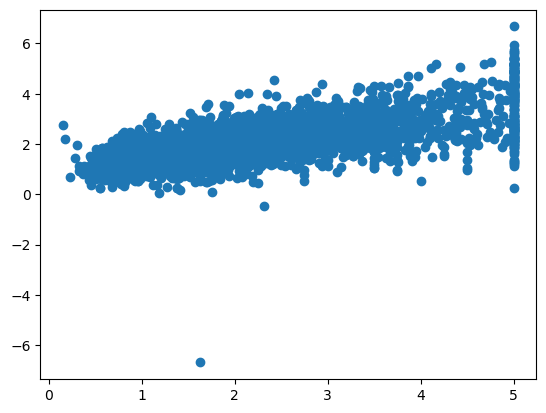

In [ ]:
plt.scatter(y_test, test_preds)
